In [2]:
import torch
from torch import nn, optim
from tqdm import tqdm
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [10]:
LATENT_DIM = 64  # Latent space dimension
NUM_EMBEDDINGS = 128  # Number of vectors in codebook
COMMITMENT_COST = 0.25  # Beta in loss function
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=False, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True
)

In [38]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, latent_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  # No activation, raw latents
        return x

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
    
    def forward(self, x):
        B, C, H, W = x.shape  # Get input shape
        x_flattened = x.permute(0, 2, 3, 1).contiguous().view(-1, C)
        distances = torch.cdist(x_flattened, self.embedding.weight)
        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(encoding_indices).view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        
        loss = F.mse_loss(quantized.detach(), x) + self.commitment_cost * F.mse_loss(x.detach(), quantized)
        quantized = x + (quantized - x).detach()
        
        return quantized, loss, quantized

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))  # Output in [0,1]
        return x

class VQVAE(nn.Module):
    def __init__(self, latent_dim, num_embeddings, commitment_cost):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.vq = VectorQuantizer(num_embeddings, latent_dim, commitment_cost)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, encodings = self.vq(z_e)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss, encodings

Epoch 1/10, Recon Loss: 0.0670, VQ Loss: 0.0201
Epoch 2/10, Recon Loss: 0.0113, VQ Loss: 0.0008
Epoch 3/10, Recon Loss: 0.0083, VQ Loss: 0.0007
Epoch 4/10, Recon Loss: 0.0075, VQ Loss: 0.0006
Epoch 5/10, Recon Loss: 0.0071, VQ Loss: 0.0006
Epoch 6/10, Recon Loss: 0.0069, VQ Loss: 0.0006
Epoch 7/10, Recon Loss: 0.0067, VQ Loss: 0.0006
Epoch 8/10, Recon Loss: 0.0066, VQ Loss: 0.0006
Epoch 9/10, Recon Loss: 0.0065, VQ Loss: 0.0006
Epoch 10/10, Recon Loss: 0.0064, VQ Loss: 0.0006
Image 0: Encodings:
[[[-0.05678825 -0.04099928 -0.126525   ...  0.19770195  0.1302585
   -0.126525  ]
  [-0.06641877 -0.09142515  0.15864164 ...  0.04246698  0.29576176
   -0.10313282]
  [-0.06641877 -0.05513486  0.07119986 ...  0.18052556  0.13393053
   -0.08265574]
  ...
  [-0.09142515  0.24918135  0.22701743 ...  0.3353352   0.17325376
   -0.06604346]
  [-0.02932543  0.18920119  0.28045505 ... -0.11098219  0.01215224
   -0.04099928]
  [-0.08839275 -0.08428497 -0.08428497 ... -0.08218917 -0.08265574
   -0.066418

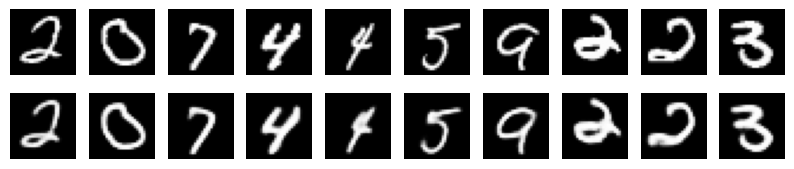

In [43]:
def train_vqvae(model, train_loader, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        total_loss, total_vq_loss = 0, 0
        for x, _ in train_loader:
            x = x.to(device)
            def add_noise(image, noise_factor=0.3):
                noise = torch.randn_like(image) * noise_factor
                noisy_image = image + noise
                return torch.clamp(noisy_image, 0., 1.)  

            noisy_images = add_noise(x)

            x_recon, vq_loss, _ = model(noisy_images)
            optimizer.zero_grad()
            recon_loss = criterion(x_recon, x)
            loss = recon_loss + vq_loss
            loss.backward()
            optimizer.step()
            total_loss += recon_loss.item()
            total_vq_loss += vq_loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Recon Loss: {total_loss/len(train_loader):.4f}, VQ Loss: {total_vq_loss/len(train_loader):.4f}")

def visualize_reconstructions(model, test_loader):
    model.eval()
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_recon, _, encodings = model(x)
            break  # Take only one batch
    
    x, x_recon = x.cpu().numpy(), x_recon.cpu().numpy()
    encodings = encodings.cpu().numpy()
    
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(x[i, 0], cmap='gray')
        axes[1, i].imshow(x_recon[i, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        print(f"Image {i}: Encodings:\n{encodings[i]}")
    plt.show()
    return encodings

# Main Execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQVAE(LATENT_DIM, NUM_EMBEDDINGS, COMMITMENT_COST).to(device)
train_vqvae(model, train_loader, EPOCHS, LEARNING_RATE)
enc = visualize_reconstructions(model, test_loader)


[[[ 0.5503363  -0.4537129   0.9134243  ...  0.6058483  -0.05973936
    0.23667742]
  [-0.7677581   0.40976772  0.04746637 ...  0.19805364  0.73447335
    0.39280206]
  [-0.8652384   0.03524564  0.16162165 ...  1.          1.
   -0.80266523]
  ...
  [-0.35874948  0.07573236 -0.00195857 ... -0.20796438  0.25835332
    0.6175431 ]
  [-0.22905768  1.          0.33569872 ... -0.28076673 -0.15698889
    0.32865947]
  [ 0.06793055  0.30064    -1.         ...  0.37124017 -0.48504382
   -0.06180569]]

 [[-0.40505937 -0.27063504  0.8386794  ... -0.47038215  1.
   -0.3832748 ]
  [ 0.6481962   1.         -0.27529055 ...  0.3243569  -0.5958061
    1.        ]
  [-0.53428334  0.80647874 -0.16351092 ... -0.9244261   0.7765761
    0.57404256]
  ...
  [-0.34164575 -0.5235697  -1.         ... -0.39534777 -0.19265226
   -0.1738865 ]
  [ 1.          0.31136987  0.78244126 ...  0.7505534  -0.00123253
   -0.21078289]
  [ 0.10356048  0.6664336   0.37944344 ...  0.6322595   0.5210637
    0.08601603]]

 [[ 0.3

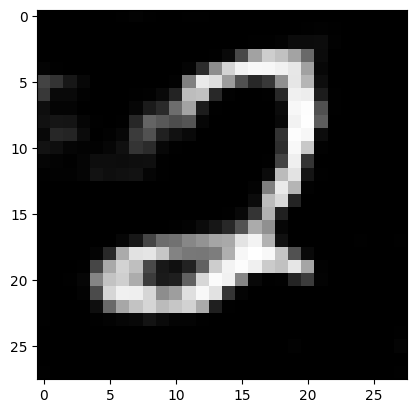

In [53]:
arr = enc[0]
noise = np.random.normal(0, 0.6, arr.shape)
noisy_arr = np.clip(arr + noise, -1, 1)  # Clip to valid range (0-255)

print(noisy_arr.astype(np.float32))
# Convert NumPy array to PyTorch tensor
noisy_tensor = torch.tensor(noisy_arr.astype(np.float32))  # Ensure it's float32

noisy_tensor = noisy_tensor.unsqueeze(0)  # Add batch dimension: (1, 7, 7)
noisy_tensor = noisy_tensor.expand(1, 64, 7, 7)  # Expand channels to 64: (1, 64, 7, 7)


# Move to the same device as the model
noisy_tensor = noisy_tensor.to(device)

# Pass through decoder
output = model.decoder(noisy_tensor)

# Convert output back to NumPy for visualization
output_np = output.squeeze().cpu().detach().numpy()
print(output_np)

plt.imshow(output_np, cmap='gray')

In [ ]:
class VQ_VAE_Models(nn.Module):
    def __init__(self, latent_dim):
        super(VQ_VAE_Models, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, 4, stride=2, padding=1)
        )
        
        self.vq = nn.Sequential(
            nn.Conv2d(latent_dim, latent_dim, 1),
            nn.ReLU()
        )